## -------------------------------------------------------------------------
## YOUR SUBMISSION WILL NOT BE RECORDED UNLESS YOU COMPLETE YOUR DETAILS HERE
### *replace the text in the brackets below with your own details*

### NAME: [Robert, Muturi]
### EMAIL: [robertmuturi5@gmail.com]

## -------------------------------------------------------------------------

## Simplyfied Replication of Storeygard (2016) 

In this assignment you have to generate the (simplyfied) final dataset used in **"Farther on down the road: transport costs, trade and urban growth"** (2016) Review of Economic Studies 83(3): 1263-1295. For this assignment, we are going to focus on **Tanzania** for the year **1992** and **2013**.

The final dataset (6 columns, 148 raws) should contained:
   - 74 Tanzanian city names (repeated twice for 1992 and 2013)
   - city populations (same value for 1992 and 2013)
   - a column for the year (1992 and 2013)
   - light values in both years (1992 and 2013)
   - oil prices in both years (1992 and 2013) 
   - distance to the primary city (same value for 1992 and 2013)

The objective is to use the geoprocessing tools and routines seen in class to solve the intermediate steps needed to assemble the final dataset. 

We have organized the assigment into 6 blocks:

1. Identify Tanzanian Cities
2. Compute total light emitted by each city in 1992 and 2013
3. Identify Tanzania's primary city
4. Create a routable road network
5. Find optimal paths between cities
6. Build the final dataset

Each section and subsection provide a detailed explanation of

- Inputs: shapefiles, raster
- Task objective and description
- Output

We are providing the packages we exepect you to use as well as the Coordinate Reference Systems.

Good luck!


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
import networkx as nx
from rasterio.mask import mask

In [2]:
#set shapely as default geometry engine
#gpd.options.use_pygeos = False

In [3]:
# Defining Coordinate Reference System to use throughout the whole notebook
wgs84_crs = CRS.from_string('EPSG:4326') # WGS 1984
aeaa_crs = CRS.from_string("esri:102022") # albers equal area africa crs
aedc_crs = CRS.from_string("esri:102023") # Africa equidistant conic

# 1. Identify Tanzanian cities

The unit of observations is the city. Later on, we would to like to calculate average luminosity in both 1992 and 2013 for each city. To do that we need to have a polygon associated with each city. We need to find a way to assign a city name to its corresponding polygon.

- We have provided point locations of cities around the world (`citypop_v4_latlons.csv`) and their maximal night lights extents (`city_extents.shp`)

- Write code to identify, in Tanzania, light extents with known cities and discard light extends that cannot be identified with a city




Using pathlib library to get specify file paths in use

In [4]:
#import pathlib to manage filepaths
import pathlib

mainpath = pathlib.Path('C:/Users/Joe/Documents/PYTHON/WHEELER INSTITUTE/GIS_Research_2023/assignment')
mainpath = mainpath.resolve()
inpath = mainpath/'data/cleaned'

cities_dir = inpath/'cities'
city_extents_dir = inpath/'city_extents'
lights_dir = inpath/'lights'
oil_dir = inpath/'oil'
roads_dir = inpath/'roads'
tza_poly_dir = inpath/'tza_poly'

reading in the files

In [5]:
#read in the files
city = pd.read_csv(cities_dir/'citypop_v4_latlons.csv')
city_ext = gpd.read_file(city_extents_dir/'city_extents.shp')

In [6]:
#visualise the data
city.head()

,Unnamed: 0,iso3v10,rowtot,orderincountry,url,nameraw,nametmp,nametmp2,nametmp3,nametmp4,...,country,name,lat,lon,pop,date,note,type,ISOname,samplecountry
0,0,COM,423,1,http://www.citypopulation.de/gmaps/index.html?...,Djoi%C3%A8zi%20,Djoièzi,Djoièzi,Djoièzi,Djoièzi,...,Comoros,Djoièzi,-12.305139,43.774937,2479,7/1/2002,NaN,E,COMDjoièzi,0
1,1,COM,422,2,http://www.citypopulation.de/gmaps/index.html?...,Domoni,Domoni,Domoni,Domoni,Domoni,...,Comoros,Domoni,-12.261058,44.530937,13254,7/1/2002,NaN,E,COMDomoni,0
2,2,COM,421,3,http://www.citypopulation.de/gmaps/index.html?...,Fomboni,Fomboni,Fomboni,Fomboni,Fomboni,...,Comoros,Fomboni,-12.283330,43.741720,13053,7/1/2002,NaN,E,COMFomboni,0
3,3,COM,420,4,http://www.citypopulation.de/gmaps/index.html?...,Foumbouni,Foumbouni,Foumbouni,Foumbouni,Foumbouni,...,Comoros,Foumbouni,-11.865192,43.493687,4225,7/1/2002,NaN,E,COMFoumbouni,0
4,4,COM,419,5,http://www.citypopulation.de/gmaps/index.html?...,Iconi,Iconi,Iconi,Iconi,Iconi,...,Comoros,Iconi,-11.744673,43.232136,6989,7/1/2002,NaN,E,COMIconi,0


selecting columns to use

In [7]:
#drop unnecessary columns
city = city.drop(columns=['url', 'countryraw', 'dateraw', 'typeraw', 'nameraw', 'nametmp', 'nametmp2', 'nametmp3', 'nametmp4', 'ISOname', 'type', 'note', 'samplecountry', 'Unnamed: 0'])
city.head()


,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date
0,COM,423,1,Comoros,Djoièzi,-12.305139,43.774937,2479,7/1/2002
1,COM,422,2,Comoros,Domoni,-12.261058,44.530937,13254,7/1/2002
2,COM,421,3,Comoros,Fomboni,-12.283330,43.741720,13053,7/1/2002
3,COM,420,4,Comoros,Foumbouni,-11.865192,43.493687,4225,7/1/2002
4,COM,419,5,Comoros,Iconi,-11.744673,43.232136,6989,7/1/2002


In [8]:
#view the crs of city_ext
city_ext.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
#view city_ext
city_ext

,FID,geometry
0,0,"POLYGON ((31.39583 -1.00417, 31.43750 -1.00417..."
1,1,"POLYGON ((31.24583 -1.19583, 31.28750 -1.19583..."
2,2,"POLYGON ((31.39583 -1.19583, 31.42083 -1.19583..."
3,3,"POLYGON ((31.79583 -1.27917, 31.80417 -1.27917..."
4,4,"POLYGON ((34.36250 -1.30417, 34.37917 -1.30417..."
...,...,...
235,235,"POLYGON ((39.62083 -10.74583, 39.63750 -10.745..."
236,236,"POLYGON ((34.96250 -10.90417, 34.98750 -10.904..."
237,237,"POLYGON ((39.26250 -10.90417, 39.27083 -10.904..."
238,238,"POLYGON ((37.32917 -11.00417, 37.34583 -11.004..."


In [10]:
#create a new dataframe with from Tanzania in the country column
tz = city[city['country'] == 'Tanzania']

#visualise the data
tz.head()

,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date
2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002
2181,TZA,2300,2,Tanzania,Babati,-4.211111,35.751390,30975,8/1/2002
2182,TZA,2299,3,Tanzania,Bagamoyo,-6.441667,38.897220,28368,8/1/2002
2183,TZA,2298,4,Tanzania,Bariadi,-2.798611,33.981945,15462,8/1/2002
2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002


In [11]:
#convert the dataframe to a geodataframe
tz = gpd.GeoDataFrame(tz, geometry=gpd.points_from_xy(tz['lon'], tz['lat']), crs=wgs84_crs)
tz.head()


,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,geometry
2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002,POINT (36.68472 -3.37333)
2181,TZA,2300,2,Tanzania,Babati,-4.211111,35.751390,30975,8/1/2002,POINT (35.75139 -4.21111)
2182,TZA,2299,3,Tanzania,Bagamoyo,-6.441667,38.897220,28368,8/1/2002,POINT (38.89722 -6.44167)
2183,TZA,2298,4,Tanzania,Bariadi,-2.798611,33.981945,15462,8/1/2002,POINT (33.98195 -2.79861)
2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,POINT (31.80000 -1.31667)


In [12]:
city_ext.dtypes

FID            int64
geometry    geometry
dtype: object

Find city extents in Tanzanian cities

In [13]:
#to identify the city extents that are in Tanzania, we can use the spatial join function
tz_ext = gpd.sjoin(city_ext, tz, how='inner', op='contains')


c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


visualising the selection

<Axes: >

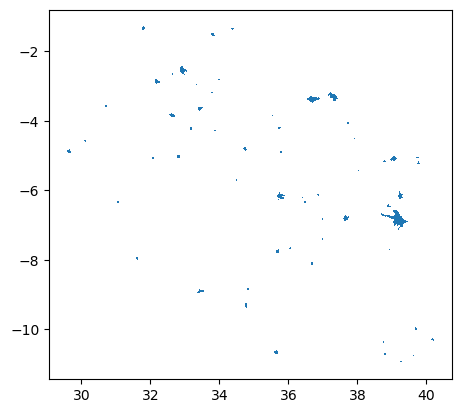

In [14]:
#plot the city extents in Tanzania
tz_ext.plot()

# 2. Compute total light emitted by each city in 1992 and 2013

Now that you manage to assign each city point to a polygon, your task is to calculate the average luminosity level for each polygon for the years 1992 and 2013.

- We have provided raster data of nighttime lights in Tanzania for 1992 and 2013 (`tza_lights_1992.tif` and `tza_lights_2013.tif`). 

- Combine them with the identified city extents above to compute total light emitted by each city in both years

- As a sanity check, make scatterplots of population against night lights (use log scale for better results). Hint: the two should be positevely correlated!

Read in the raster files

In [15]:
#read in nightlights raster data
tz_lights_1992 = rasterio.open(lights_dir/'tza_lights_1992.tif')
tz_lights_2013 = rasterio.open(lights_dir/'tza_lights_2013.tif')

In [16]:
#view the crs of the lights data
print(tz_lights_1992.crs)
print(tz_lights_2013.crs)

EPSG:4326
EPSG:4326


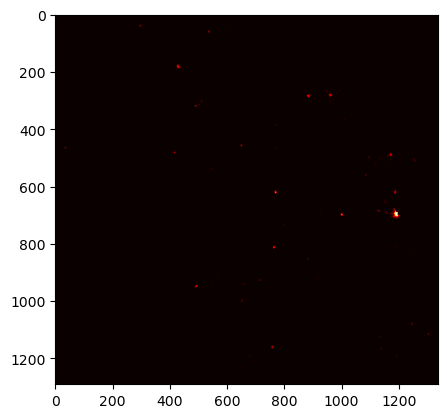

In [17]:
#visualise the 1992 lights data
plt.imshow(tz_lights_1992.read(1), cmap='hot')


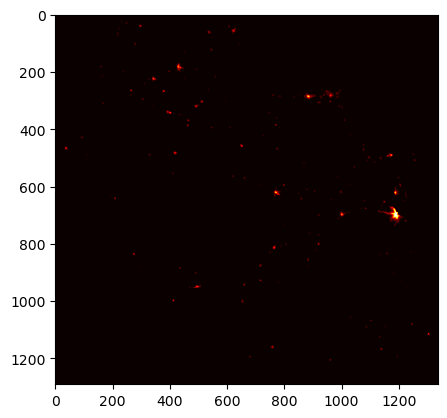

In [18]:
#visualise the 2013 lights data
plt.imshow(tz_lights_2013.read(1), cmap='hot')

In [19]:
#read raster as an array
tz_1992_array = tz_lights_1992.read(1)
tz_2013_array = tz_lights_2013.read(1)

In [20]:
#combine the 1992 and 2013 lights with the city extents
tz_ext_1992 = zonal_stats(tz_ext, tz_lights_1992.read(1), affine=tz_lights_1992.transform, stats='mean')
tz_ext_2013 = zonal_stats(tz_ext, tz_lights_2013.read(1), affine=tz_lights_2013.transform, stats='mean')

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [21]:
tz_ext['lights_1992'] = [x['mean'] for x in tz_ext_1992]
tz_ext['lights_2013'] = [x['mean'] for x in tz_ext_2013]

In [22]:
tz_ext

,FID,geometry,index_right,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,lights_1992,lights_2013
3,3,"POLYGON ((31.79583 -1.27917, 31.80417 -1.27917...",2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,4.255556,9.688889
4,4,"POLYGON ((34.36250 -1.30417, 34.37917 -1.30417...",2279,TZA,2202,100,Tanzania,Tarime,-1.345833,34.366665,29215,8/1/2002,1.302326,6.418605
6,6,"POLYGON ((33.77917 -1.46250, 33.82083 -1.46250...",2254,TZA,2227,75,Tanzania,Musoma,-1.500000,33.783333,104851,8/1/2002,4.872549,8.852941
18,18,"POLYGON ((32.89583 -2.41250, 32.94583 -2.41250...",2186,TZA,2295,7,Tanzania,Butimba,-2.566945,32.914444,31030,8/1/2002,5.318519,13.624691
18,18,"POLYGON ((32.89583 -2.41250, 32.94583 -2.41250...",2266,TZA,2215,87,Tanzania,Nyakato,-2.537500,32.947224,82080,8/1/2002,5.318519,13.624691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,229,"POLYGON ((38.73750 -10.32917, 38.76250 -10.329...",2258,TZA,2223,79,Tanzania,Nachingwea,-10.372222,38.758330,14353,8/1/2002,4.058824,5.705882
233,233,"POLYGON ((35.63750 -10.60417, 35.66250 -10.604...",2274,TZA,2207,95,Tanzania,Songea,-10.666667,35.633330,98683,8/1/2002,7.336066,8.188525
234,234,"POLYGON ((38.79583 -10.67917, 38.82083 -10.679...",2234,TZA,2247,55,Tanzania,Masasi,-10.716667,38.798610,34034,8/1/2002,3.409836,7.852459
235,235,"POLYGON ((39.62083 -10.74583, 39.63750 -10.745...",2277,TZA,2204,98,Tanzania,Tandahimba,-10.752777,39.625000,10713,8/1/2002,0.000000,5.666667


In [23]:
#check data types
tz_ext.dtypes

FID                  int64
geometry          geometry
index_right          int64
iso3v10             object
rowtot               int64
orderincountry       int64
country             object
name                object
lat                float64
lon                float64
pop                 object
date                object
lights_1992        float64
lights_2013        float64
dtype: object

In [24]:
#convert pop column to int
tz_ext['pop'] = tz_ext['pop'].astype(int)

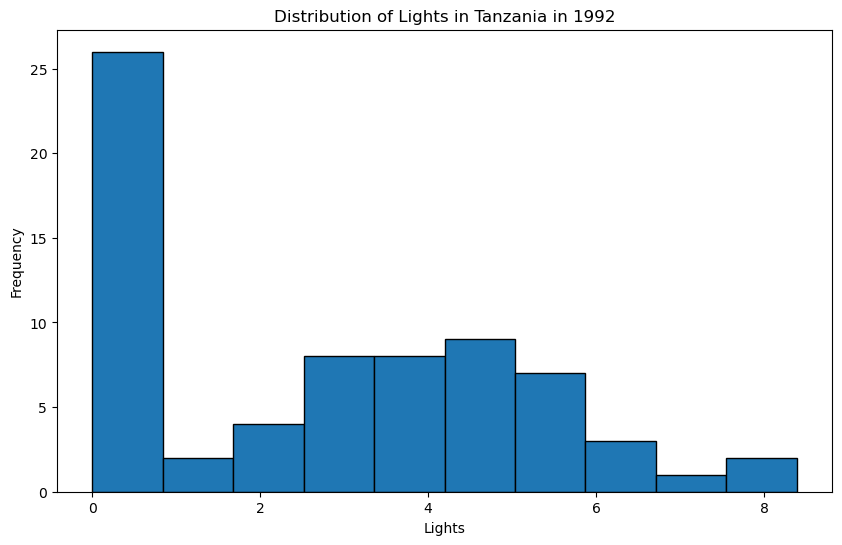

In [25]:
#plot the distribution of lights in 1992
f, ax = plt.subplots(figsize=(10, 6))
ax.hist(tz_ext['lights_1992'], bins=10, edgecolor='black')
ax.set_title('Distribution of Lights in Tanzania in 1992')
ax.set_xlabel('Lights')
ax.set_ylabel('Frequency')
plt.show()

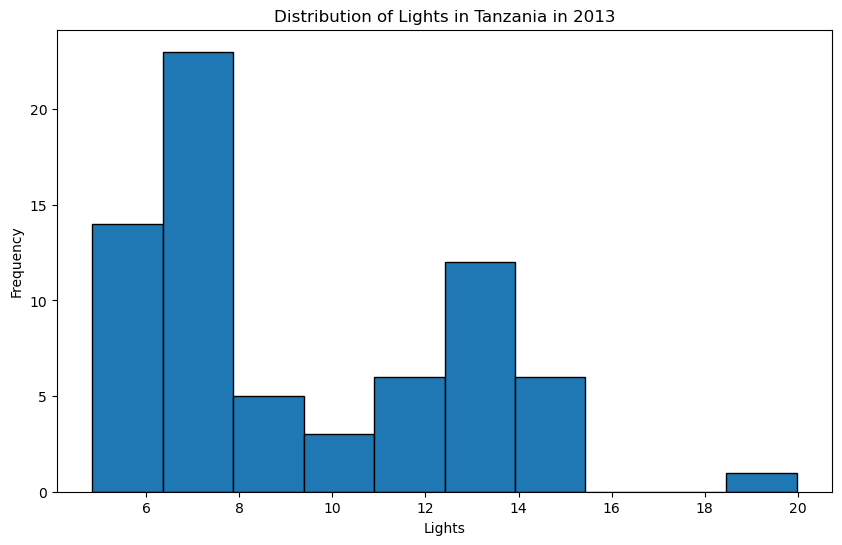

In [26]:
#plot the distribution of lights in 2013
f, ax = plt.subplots(figsize=(10, 6))
ax.hist(tz_ext['lights_2013'], bins=10, edgecolor='black')
ax.set_title('Distribution of Lights in Tanzania in 2013')
ax.set_xlabel('Lights')
ax.set_ylabel('Frequency')
plt.show()

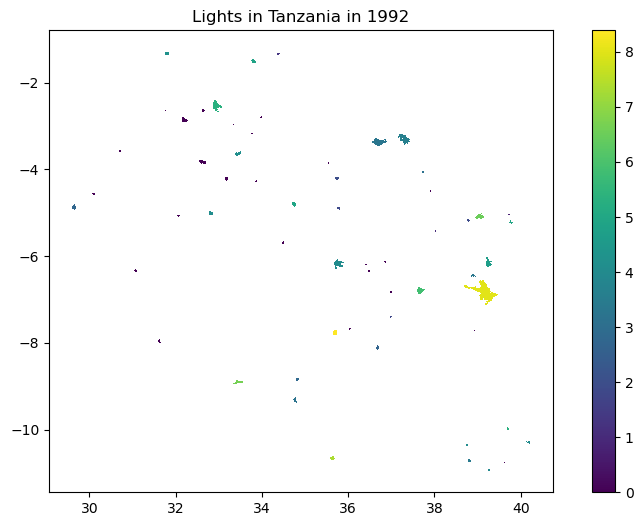

In [27]:
#plot map of lights in 1992
f, ax = plt.subplots(figsize=(10, 6))
tz_ext.plot(column='lights_1992', ax=ax, legend=True)
ax.set_title('Lights in Tanzania in 1992')
plt.show()

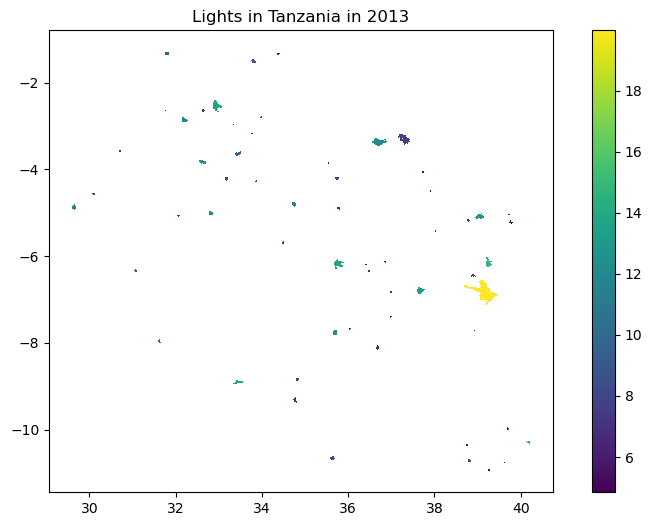

In [28]:
#plot map of lights in 2013
f, ax = plt.subplots(figsize=(10, 6))
tz_ext.plot(column='lights_2013', ax=ax, legend=True)
ax.set_title('Lights in Tanzania in 2013')
plt.show()

Please make scatterplots of population against night lights (in log scale) below. 

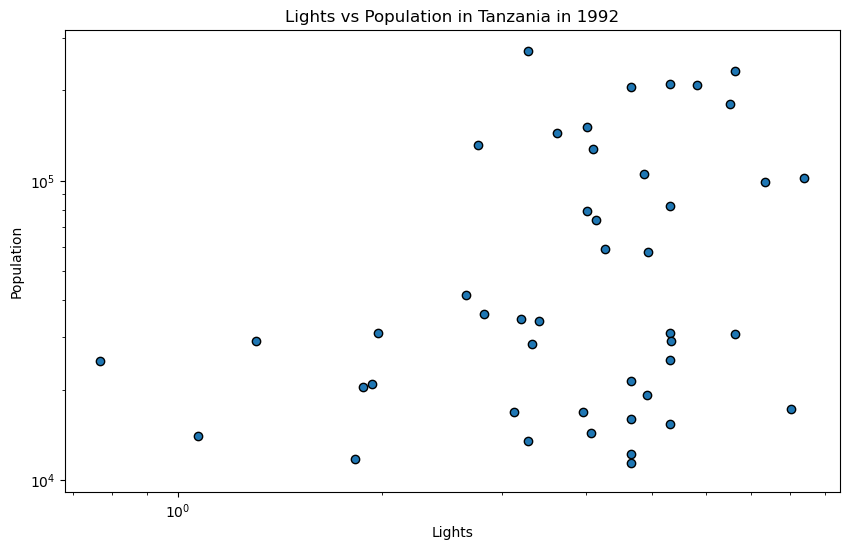

In [29]:
#create scatter plot of lights against population in 1992 in log scale
f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(tz_ext['lights_1992'], tz_ext['pop'], edgecolor='black')
ax.set_title('Lights vs Population in Tanzania in 1992')
ax.set_xlabel('Lights')
ax.set_ylabel('Population')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

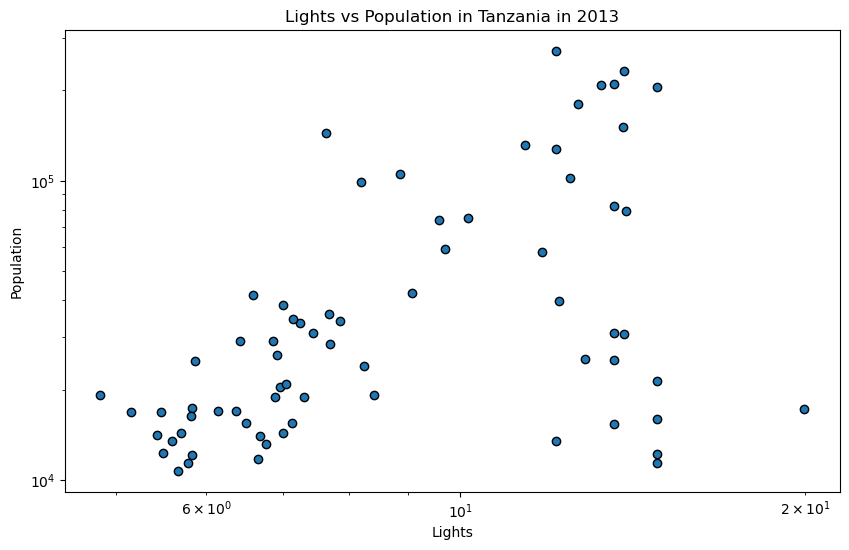

In [30]:
#create scatter plot of lights against population in 2013 in log scale
f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(tz_ext['lights_2013'], tz_ext['pop'], edgecolor='black')
ax.set_title('Lights vs Population in Tanzania in 2013')
ax.set_xlabel('Lights')
ax.set_ylabel('Population')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# 3. Identify Tanzania's primary city

To make things simple, we call the primary city the one with the largest population. 

- Find the primary city.

- Plot the primary city with one color
- Plot all cities except the primary with a different color

- Add the outline of Tanzania to the plot (this is available in the file `tza_poly/tza_polygon.shp` we have provided for you)

In [31]:
#view tz_ext
tz_ext.head()

,FID,geometry,index_right,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,lights_1992,lights_2013
3,3,"POLYGON ((31.79583 -1.27917, 31.80417 -1.27917...",2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,4.255556,9.688889
4,4,"POLYGON ((34.36250 -1.30417, 34.37917 -1.30417...",2279,TZA,2202,100,Tanzania,Tarime,-1.345833,34.366665,29215,8/1/2002,1.302326,6.418605
6,6,"POLYGON ((33.77917 -1.46250, 33.82083 -1.46250...",2254,TZA,2227,75,Tanzania,Musoma,-1.500000,33.783333,104851,8/1/2002,4.872549,8.852941
18,18,"POLYGON ((32.89583 -2.41250, 32.94583 -2.41250...",2186,TZA,2295,7,Tanzania,Butimba,-2.566945,32.914444,31030,8/1/2002,5.318519,13.624691
18,18,"POLYGON ((32.89583 -2.41250, 32.94583 -2.41250...",2266,TZA,2215,87,Tanzania,Nyakato,-2.537500,32.947224,82080,8/1/2002,5.318519,13.624691


In [32]:
#read in tz poly
tz_poly = gpd.read_file(tza_poly_dir/'tza_polygon.shp')
tz_poly

,FID,geometry
0,0,"MULTIPOLYGON (((39.89382 -7.75415, 39.86540 -7..."


In [33]:
#idenstify Tanzania's primary city using max population
main_city = tz_ext[tz_ext['pop'] == tz_ext['pop'].max()]
main_city

,FID,geometry,index_right,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,lights_1992,lights_2013
58,58,"POLYGON ((36.64583 -3.27083, 36.65417 -3.27083...",2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002,3.284658,12.120148


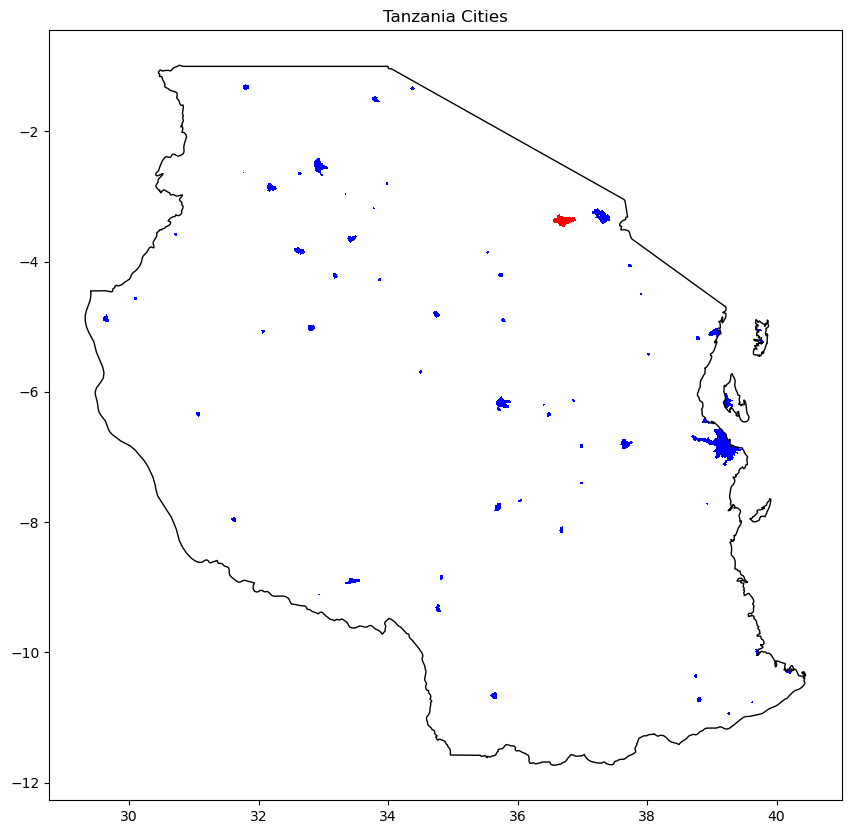

In [34]:
#plot all other cities with different colour to main city
fig, ax = plt.subplots(figsize=(15,10))
tz_ext[tz_ext['pop'] != tz_ext['pop'].max()].plot(ax=ax, color='blue')
main_city.plot(ax=ax, color='red')
tz_poly.plot(ax=ax, color='None', edgecolor='black')
ax.set_title('Tanzania Cities')
plt.show()

# 4. Create a routable road network

As part of the identification stratey in Storeygard (2016), we need to compute the distance between each city and the primary city following the road network. In this section we will prepare the network, in section 5 we will solve it with the Djkstra's algorithm for the least costly path. 

The network should have the following elements: i) city points (as nodes), ii) roads (as edges), iii) connectors from city to roads (as edges)

- Using the file `roads.shp` we have provided for you as well as the point locations of identified cities in Section 1, create a network dataset that you can use to find shortest paths

- While this is somewhat involved, you have seen this exact procedure in the lecture on Donaldson and Hornbeck's paper on the American railroad. The steps we show there are what is needed here: you just need to adapt the code to fit the inputs for this application!

- For the costs, you can assume the following parameters (these relative costs are made up):
    - `cost_per_km_paved` = 1
    - `cost_per_km_unpaved` = 4
    
- For the connector pieces connecting city points to the road network, you can assume that they are paved

## 4.1 Create Road connectors to the cities points

In this subsection, you will generate the connectors from the cities to the closest road segment

In [35]:
#read in roads data
roads = gpd.read_file(roads_dir/'roads.shp')
roads.head()

,surface,geometry
0,paved,"LINESTRING (39.30001 -5.93096, 39.30004 -5.931..."
1,unpaved,"LINESTRING (39.29786 -5.72847, 39.29788 -5.728..."
2,unpaved,"LINESTRING (39.32655 -6.09492, 39.32637 -6.093..."
3,paved,"LINESTRING (39.42907 -6.16517, 39.42897 -6.164..."
4,paved,"LINESTRING (39.43831 -6.28878, 39.44091 -6.288..."


In [36]:
#Tanzania city data that we had read in
tz.head()

,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,geometry
2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002,POINT (36.68472 -3.37333)
2181,TZA,2300,2,Tanzania,Babati,-4.211111,35.751390,30975,8/1/2002,POINT (35.75139 -4.21111)
2182,TZA,2299,3,Tanzania,Bagamoyo,-6.441667,38.897220,28368,8/1/2002,POINT (38.89722 -6.44167)
2183,TZA,2298,4,Tanzania,Bariadi,-2.798611,33.981945,15462,8/1/2002,POINT (33.98195 -2.79861)
2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,POINT (31.80000 -1.31667)


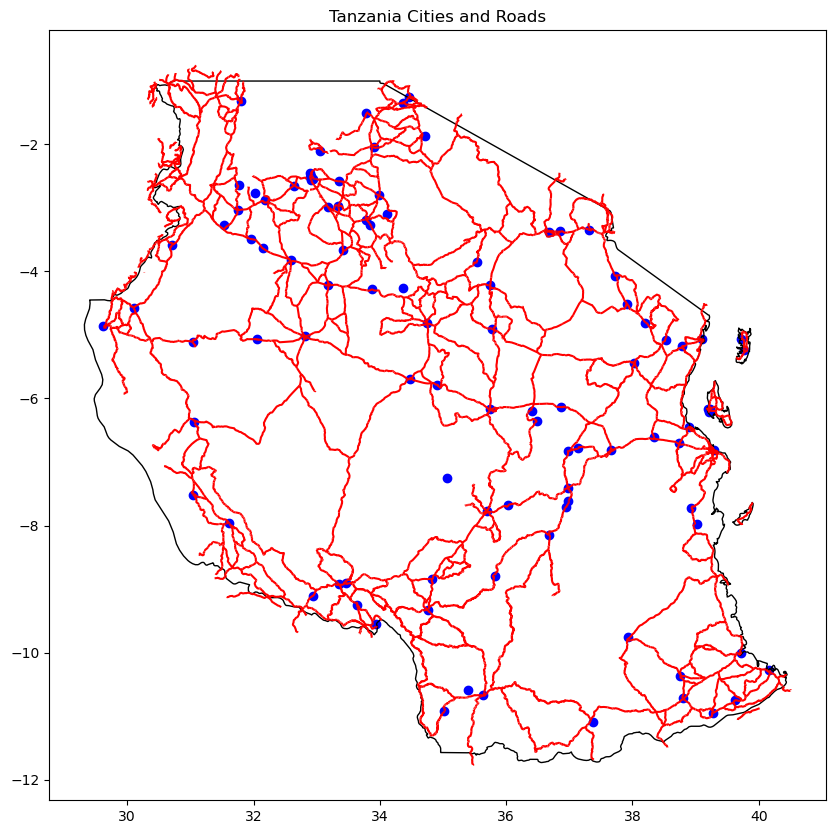

In [37]:
#plot all other cities with different colour to main city
fig, ax = plt.subplots(figsize=(15,10))
tz.plot(ax=ax, color='blue')
tz_poly.plot(ax=ax, color='None', edgecolor='black')
roads.plot(ax=ax, color='red')
ax.set_title('Tanzania Cities and Roads')
plt.show()

In [38]:
#convert roads and tz to equidistant crs
roads =  roads.to_crs(aedc_crs)
tz = tz.to_crs(aedc_crs)

In [39]:
roads.head()

,surface,geometry
0,paved,"LINESTRING (1478125.411 -660554.928, 1478128.6..."
1,unpaved,"LINESTRING (1478047.133 -638161.411, 1478048.5..."
2,unpaved,"LINESTRING (1480752.711 -678704.547, 1480735.7..."
3,paved,"LINESTRING (1491299.607 -686541.311, 1491289.6..."
4,paved,"LINESTRING (1492166.448 -700216.387, 1492435.0..."


In [40]:
tz.head()

,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,geometry
2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002,POINT (1209274.472 -376163.652)
2181,TZA,2300,2,Tanzania,Babati,-4.211111,35.751390,30975,8/1/2002,POINT (1112237.974 -468319.357)
2182,TZA,2299,3,Tanzania,Bagamoyo,-6.441667,38.897220,28368,8/1/2002,POINT (1436141.342 -716769.690)
2183,TZA,2298,4,Tanzania,Bariadi,-2.798611,33.981945,15462,8/1/2002,POINT (929815.440 -311321.884)
2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,POINT (704437.880 -146659.420)


In [41]:
#we dissolve the roads data to get a single line
roads['adm0']=1
roads_diss = roads.dissolve(by='adm0').geometry
del roads['adm0']

roads_diss

adm0
1    MULTILINESTRING ((1478125.411 -660554.928, 147...
Name: geometry, dtype: geometry

In [42]:
#create the closest point on the road to the cities
tz['closest_point'] = tz.apply(lambda x: nearest_points(x.geometry, roads_diss)[1], axis=1)
tz

,iso3v10,rowtot,orderincountry,country,name,lat,lon,pop,date,geometry,closest_point
2180,TZA,2301,1,Tanzania,Arusha,-3.373334,36.684723,270485,8/1/2002,POINT (1209274.472 -376163.652),POINT (1209286.998 -376262.362)
2181,TZA,2300,2,Tanzania,Babati,-4.211111,35.751390,30975,8/1/2002,POINT (1112237.974 -468319.357),POINT (1111997.556 -468297.389)
2182,TZA,2299,3,Tanzania,Bagamoyo,-6.441667,38.897220,28368,8/1/2002,POINT (1436141.342 -716769.690),POINT (1436484.487 -717160.430)
2183,TZA,2298,4,Tanzania,Bariadi,-2.798611,33.981945,15462,8/1/2002,POINT (929815.440 -311321.884),POINT (929724.325 -311559.754)
2184,TZA,2297,5,Tanzania,Bukoba,-1.316667,31.800000,59147,8/1/2002,POINT (704437.880 -146659.420),POINT (704342.331 -147328.069)
...,...,...,...,...,...,...,...,...,...,...,...
2288,TZA,2193,109,Tanzania,Utengule,-8.925000,33.358334,30816,8/1/2002,POINT (862730.107 -988565.489),POINT (862596.563 -988844.614)
2289,TZA,2192,110,Tanzania,Uyovu,-3.266667,31.533333,10616,8/1/2002,POINT (676183.733 -362199.767),POINT (679630.312 -365724.567)
2290,TZA,2191,111,Tanzania,Vwawa,-9.109722,32.936110,19298,8/1/2002,POINT (819076.784 -1008837.321),POINT (818986.343 -1008678.579)
2291,TZA,2190,112,Tanzania,Wete,-5.061111,39.719444,24983,8/1/2002,POINT (1522112.588 -564646.530),POINT (1523022.581 -564183.644)


In [43]:
#create connector roads
connector_roads = tz.copy()

#select columns
connector_roads = connector_roads[['closest_point', 'geometry', 'name']]
connector_roads

,closest_point,geometry,name
2180,POINT (1209286.998 -376262.362),POINT (1209274.472 -376163.652),Arusha
2181,POINT (1111997.556 -468297.389),POINT (1112237.974 -468319.357),Babati
2182,POINT (1436484.487 -717160.430),POINT (1436141.342 -716769.690),Bagamoyo
2183,POINT (929724.325 -311559.754),POINT (929815.440 -311321.884),Bariadi
2184,POINT (704342.331 -147328.069),POINT (704437.880 -146659.420),Bukoba
...,...,...,...
2288,POINT (862596.563 -988844.614),POINT (862730.107 -988565.489),Utengule
2289,POINT (679630.312 -365724.567),POINT (676183.733 -362199.767),Uyovu
2290,POINT (818986.343 -1008678.579),POINT (819076.784 -1008837.321),Vwawa
2291,POINT (1523022.581 -564183.644),POINT (1522112.588 -564646.530),Wete


In [44]:
#create line between cities and closest point on road
connector_roads['geometry'] = [LineString([x['closest_point'], x['geometry']]) if x['closest_point'] is not None else None for _, x in connector_roads.iterrows()]


In [45]:
#delete columns
del connector_roads['closest_point'], tz['closest_point']

In [46]:
#check the crs if they are the same
tz.crs == connector_roads.crs == roads.crs

True

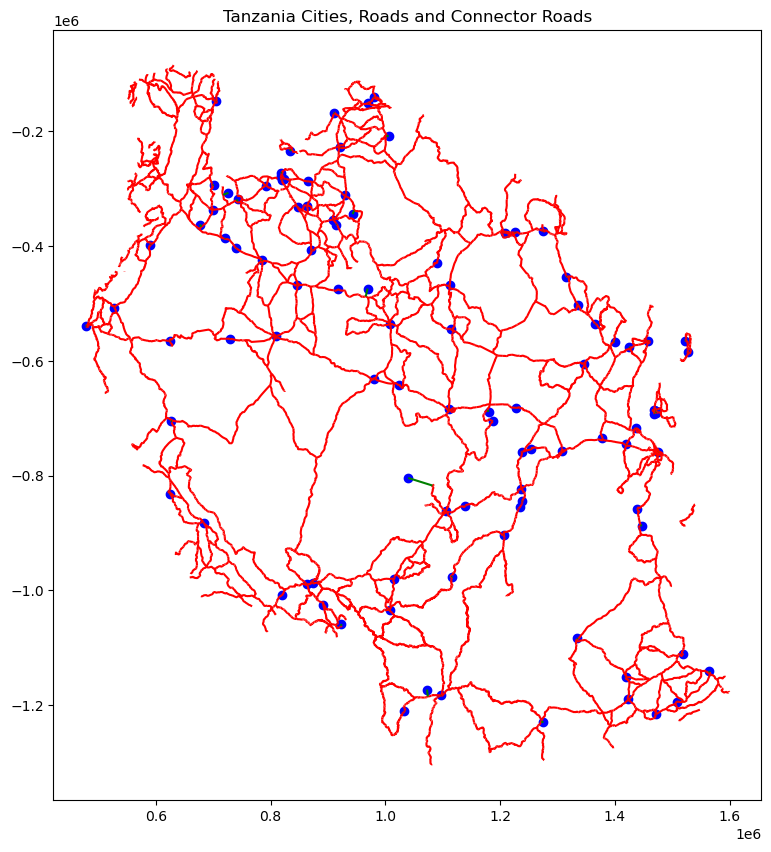

In [47]:
#plot tz, roads and connector roads
fig, ax = plt.subplots(figsize=(15,10))
tz.plot(ax=ax, color='blue')
#tz_poly.plot(ax=ax, color='None', edgecolor='black')
roads.plot(ax=ax, color='red')
connector_roads.plot(ax=ax, color='green')
ax.set_title('Tanzania Cities, Roads and Connector Roads')
plt.show()

## 4.2 Deal with connectivity issues

As discussed in class, drawing the connectors is not sufficient to ensure full connectivity due to numerical precision. 

- Rescale the connectors by a small factor. Hint: There is one city connector that needs an extra large rescaling!


In [48]:
#rescale connector roads
connector_roads_scaled = connector_roads.copy()
connector_roads_scaled_illustration = connector_roads.copy()
connector_roads_scaled['geometry'] = connector_roads_scaled.geometry.scale(xfact=1.5, yfact=1.5)
connector_roads_scaled_illustration['geometry'] = connector_roads_scaled_illustration.geometry.scale(xfact=1.5, yfact=1.5)

In [49]:
#create a copy of Tanzania cities
tz_mod = tz.copy()
tz_mod = tz_mod[['geometry', 'name']]
tz_mod

,geometry,name
2180,POINT (1209274.472 -376163.652),Arusha
2181,POINT (1112237.974 -468319.357),Babati
2182,POINT (1436141.342 -716769.690),Bagamoyo
2183,POINT (929815.440 -311321.884),Bariadi
2184,POINT (704437.880 -146659.420),Bukoba
...,...,...
2288,POINT (862730.107 -988565.489),Utengule
2289,POINT (676183.733 -362199.767),Uyovu
2290,POINT (819076.784 -1008837.321),Vwawa
2291,POINT (1522112.588 -564646.530),Wete


In [50]:
#reset index
tz_mod.reset_index(inplace=True)
connector_roads_scaled.reset_index(inplace=True, drop=True)
connector_roads_scaled_illustration.reset_index(inplace=True, drop=True)

Remember that after you applied the rescaling you also need to snap the cities' location to the rescaled connectors. This is achieved by the function below

In [51]:
def snap_points_to_modified_connectors(points_gdf, connectors_gdf):
    
    out = points_gdf.copy()
    
    for index, row in points_gdf.iterrows():
        
        tmp_gdf = connectors_gdf.copy()
        tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
        closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[0]
        closest_pts = [Point(coords) for coords in closest_geom.coords]
        dists = [row['geometry'].distance(x) for x in closest_pts]
        minimum = min(dists)
        minimum_index = [i for i, j in enumerate(dists) if j == minimum][0]   
        out.loc[index, 'geometry'] = closest_pts[minimum_index]
        
    return out

Use the function above, to snap the identified city to the rescale connectors

In [52]:
modified_cities = snap_points_to_modified_connectors(tz_mod, connector_roads_scaled)
modified_cities_illustration = snap_points_to_modified_connectors(tz_mod, connector_roads_scaled_illustration)

IndexError: list index out of range

## 4.3 Join roads and connectors

Now you can join the roads and the rescaled connectors to finalize the construction of your network edges

In [ ]:
#create column for transport type
roads['transport_type'] = 'road'
connector_roads['transport_type'] = 'connector_road'
connector_roads_scaled['transport_type'] = 'connector_road_scaled'

In [ ]:
#append the dataframes
joined = roads.append(connector_roads)
joined_scaled = roads.append(connector_roads_scaled)

AttributeError: 'GeoDataFrame' object has no attribute 'append'

## 4.4 Examine connectivity

Now we can examine the connectivity of the network you created. 

Remember that to build the network you need to define the following function

In [ ]:
# taken from here:
# https://www.reddit.com/r/gis/comments/b1ui7h/geopandas_how_to_make_a_graph_out_of_a/

def gdf_to_nx(gdf_network):
    # generate graph from GeoDataFrame of LineStrings
    net = nx.Graph()
    net.graph['crs'] = gdf_network.crs
    fields = list(gdf_network.columns)

    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        net.add_edge(first, last, **attributes)

    return net

Build the network!

Also generate a geodataframe with the number of connected component for each city. [again check carefully the network notebook for Donalson and Hornbeck's replication]

Now plot it! 

If you see an unconnected city (number of components=2), then go back to Section 4.2 and inspect the data better!

## 4.5 Add costs

Now you are ready to assign the costs to paved and unpaved roads.

# 5. Find optimal paths between cities

Now that your network is routable, fully connected, and costs are specified, you can solve it!

- Using the roads and cities network created in step 4, solve the network to find the shortest paths
- Once again, you should follow the code we have provided during the lecture on Donaldson and Hornbeck's paper on the American railroad

- Now iterate over the list of centroids to grab the elements from the dictionary and insert them into a list of lists into the right order. 
- Finally, convert the  list of lists into a `pandas` dataframe. 

Notice that for this application we would just need the distance of each city to the primary city!

- Create a dataframe having 2 columns: i) city names and ii) distance to primary city.

# 6. Build the final dataset

- The point of this data construction exercise is to build a dataset you can use to run Storeygard's regression.

- You should therefore build this dataset as a final exercise

- The dataset should have
    - city names
    - city populations
    - a column for the year
    - lights in both years
    - oil prices in both years (we have provided the oil price data in `Europe_Brent_Spot_Price_FOB.csv`)
    - distance to the primary city